<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Логистическая-регрессия" data-toc-modified-id="Логистическая-регрессия-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Логистическая регрессия</a></span></li><li><span><a href="#Дерево-решений" data-toc-modified-id="Дерево-решений-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Дерево решений</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

Импортируем все необходимые библиотеки

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import f1_score

import re
import nltk
import spacy

from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords as nltk_stopwords
from nltk.corpus import wordnet

Запишем данные в переменную, посмотрим на несколько строк и выведим info

In [2]:
data = pd.read_csv('/datasets/toxic_comments.csv')

In [3]:
data.head(10)

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0
5,5,"""\n\nCongratulations from me as well, use the ...",0
6,6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,7,Your vandalism to the Matt Shirvington article...,0
8,8,Sorry if the word 'nonsense' was offensive to ...,0
9,9,alignment on this subject and which are contra...,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


Видим, что в датасете есть столбец "Unnamed: 0" которого нет в описании данных, удалим его. Отметим что нет пропусков в данных

In [5]:
data = data.drop('Unnamed: 0', axis=1)

Проверим на дубликаты

In [6]:
data.duplicated().sum()

0

Теперь посмотрим как распределены классы целевого значения

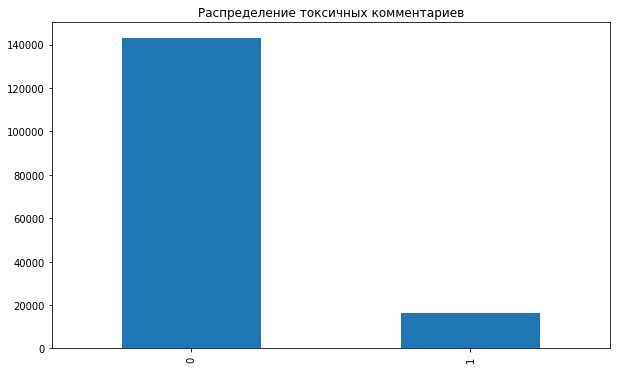

In [7]:
data['toxic'].value_counts().plot(kind='bar',title='Распределение токсичных комментариев', figsize=(10, 6));

In [8]:
data['toxic'].value_counts(normalize=True)

0    0.898388
1    0.101612
Name: toxic, dtype: float64

Отмечаем явный дисбаланс классов, соотношение обычных комментариев к токсичным 9 к 1. Учтем это в дальнейшем при обучении моделей и разбиении данных на выборки

Для дальнейшей работы с текстом проведем очистку от разных символов

In [9]:
def clear_text(text):
    
    ct = re.sub(r'[^a-zA-Z]', ' ', text)
    ct = ct.split()
    ct = " ".join(ct)
    
    return ct.lower()

Проверим правильность работы

In [10]:
data['text'] = data['text'].apply(clear_text)

In [11]:
data.head()

,text,toxic
0,explanation why the edits made under my userna...,0
1,d aww he matches this background colour i m se...,0
2,hey man i m really not trying to edit war it s...,0
3,more i can t make any real suggestions on impr...,0
4,you sir are my hero any chance you remember wh...,0


Теперь лемматизируем наш текст

In [12]:
nlp = spacy.load('en_core_web_sm')

In [13]:
def lemmatize(text): 
      
    lemm = nlp(text) 
    lemm = " ".join([token.lemma_ for token in lemm])  
    return " ".join(lemm.split())

Проверим правильность работы

In [14]:
data['text'] = data['text'].apply(lemmatize)

In [15]:
data.head()

,text,toxic
0,explanation why the edit make under my usernam...,0
1,d aww he match this background colour I m seem...,0
2,hey man I m really not try to edit war it s ju...,0
3,more I can t make any real suggestion on impro...,0
4,you sir be my hero any chance you remember wha...,0


Очистка текста и лемматизация сработали как надо

### Вывод

Мы ознакомились с датафреймом, отметили его особенности для дальнейшей работы. В ходе проверки, мы обнаружили и удалили аномальный столбец 'Unnamed: 0' и проверили на наличие дубликатов. Нами был исследован баланс классов, заметен явный дисбаланс, соотношение обычных комментариев к токсичным 9 к 1, обработкой дисбаланса займемся в следующем шаге. Функции лемматизации и очистки работают исправно.

## Обучение

Перед началом обучения моделей нам необходимо разбить данные на обучающую и тестовую выборки в соотношении 9:1, те 90 и 10 в процентах. Также укажем параметр stratify, чтобы баланс(дисбаланс =) ) классов не нарушился

In [16]:
train, test = train_test_split(data, test_size=0.1, random_state=5432, stratify=data['toxic'])

Проверим, все ли нормально

In [17]:
for i in [train, test]:
    print(i.shape)
    print()
    print(i['toxic'].value_counts(normalize=True))
    print('-----------------------------------------------')
    print()

(143362, 2)

0    0.89839
1    0.10161
Name: toxic, dtype: float64
-----------------------------------------------

(15930, 2)

0    0.898368
1    0.101632
Name: toxic, dtype: float64
-----------------------------------------------



Создадим переменные для признаков и целевого признака для всех 3 выборок

In [18]:
features_train = train.drop('toxic', axis=1)
target_train = train['toxic']

In [19]:
features_test = test.drop('toxic', axis=1)
target_test = test['toxic']

С дисбалансом данных бороться решили путем добавления гиперпараметра class_weight="balanced" в модели обучения, векторизацию и и удаление стоп слов проведем в пайплайне. Можно обучать модели

### Логистическая регрессия

Для начала уберем ошибку разделения, она мешает обучать модели

In [20]:
features_train = features_train.text

Напишем пайплайн

In [21]:
pipeline_lr = Pipeline([("vect", TfidfVectorizer(stop_words='english', sublinear_tf=True)), 
                        ("lr", LogisticRegression())]
                      )

Напишем параметры гридсёрча

In [22]:
parameters_lr = {'lr__C': (1, 5, 10),
              'lr__random_state': ([5432]),
              'lr__class_weight': (['balanced'])
                }

Обучим модель и выведим результаты

In [23]:
%%time

grid_lr = GridSearchCV(pipeline_lr, parameters_lr, scoring='f1', cv=3, n_jobs=-1)
grid_lr.fit(features_train, target_train)

print('Лучший показатель метрики F1 на кросс-валидации =', round(grid_lr.best_score_, 2))
print()
print('Гиперпараметры лучшей модели', grid_lr.best_params_)
print()

Лучший показатель метрики F1 на кросс-валидации = 0.77

Гиперпараметры лучшей модели {'lr__C': 10, 'lr__class_weight': 'balanced', 'lr__random_state': 5432}

CPU times: user 4min 25s, sys: 4min 18s, total: 8min 44s
Wall time: 8min 45s


### Дерево решений

Повторим все действия из предыдущего пункта

In [24]:
pipeline_dtс = Pipeline([("vect", TfidfVectorizer(stop_words='english', sublinear_tf=True)), 
                        ("dtc", DecisionTreeClassifier())]
                      )

In [25]:
parameters_dtс = {'dtc__max_depth': (range(1, 11, 2)),
              'dtc__random_state': ([5432]), 
              'dtc__class_weight': (['balanced'])}

In [26]:
%%time

grid_dtс = GridSearchCV(pipeline_dtс, parameters_dtс, scoring='f1', cv=3, n_jobs=-1)
grid_dtс.fit(features_train, target_train)

print('Лучший показатель метрики F1 на кросс-валидации =', round(grid_dtс.best_score_, 2))
print()
print('Гиперпараметры лучшей модели', grid_dtс.best_params_)
print()

Лучший показатель метрики F1 на кросс-валидации = 0.57

Гиперпараметры лучшей модели {'dtc__class_weight': 'balanced', 'dtc__max_depth': 9, 'dtc__random_state': 5432}

CPU times: user 2min 22s, sys: 255 ms, total: 2min 22s
Wall time: 2min 22s


### Тестирование

Выведем результаты обучения моделей в таблице для наглядности

In [27]:
data_models = pd.DataFrame(
    [round(grid_lr.best_score_, 2), round(grid_dtс.best_score_, 2)], 
     index=['LogisticRegression', 'DecisionTreeClassifier'], 
     columns=['F1']
)
data_models

,F1
LogisticRegression,0.77
DecisionTreeClassifier,0.57


Лучше на обучающей выборке показала себя модель логистической регресси, ее мы и возьмем для тестирования.

Для начала уберем ошибку разделения, она мешает обучать модели

In [28]:
features_test = features_test.text

Теперь обучим предсказание и выведим результат метрики

In [29]:
pred = grid_lr.predict(features_test)
f1 = f1_score(target_test, pred)
print('Метрика F1 на тестовой выборке =', round(f1, 2))

Метрика F1 на тестовой выборке = 0.76


Значение метрики удовлетворяет поставленной задаче в значении не меньше 75.

### Вывод

До обучения моделей мы разбили наши данные на обучающую и тестовую выборки в соотношении 9:1, те 90 и 10 в процентах,а после мы создали переменные для моделей.

Обучение моделей показало, что лучший результат метрики F1 показывает логистической регресси, на ней мы провели тестирование в ходе которого значение метрики F1 = 0.76, что удовлетворяет заданию.

## Выводы

В ходе работы были мы ознакомились с датафреймом для дальнейшей работы, отметили его особенноси, проверили на дубликаты, удалили аномальный столбец 'Unnamed: 0'. Исследование баланса классов показало наличие сильного "скоса", нейтральных комментариев больше, чем токсичных в 9 раз, исправить это мы решили с помощью гиперпараметра class_weight = "balanced" который мы применили во время обучения моделей. Так же мы "упрастили" текст лемметизацией, очистили его от разного рода символов и привели к нижнему регистру для удобства.

Перед обучением моделей мы разбили наши данные на две выборки:обучающую и тестовую, а затем разбили их на признаки и целевой признак, проверили их, чтобы дисбаланс не нарушился, ткже исправили ошибки разделения.

Само обучение показало, что наилучший результат логистической регрессии F1 = 0.77 достигается при 'lr__C': 5, а лучший результат дерева решений F1 = 0.55 при 'dtc__max_depth': 9. Можно заметить, что результат метрики у последней модели ниже, из этого можно выдвинуть гипотезу, что "деревянные" модели работают с текстами не лучшим образом.

Для тестирования мы выбрали логистическую регрессию и результатом является метрика F1 = 0.76, что удовлетворяет поставленной задачи в достижении значения метрики большей или равной 0.75, те обученная нами модель работает на должном уровне